In [1]:
# import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from matplotlib.pyplot import figure

import tensorflow as tf
import tensorflow_recommenders as tfrs
from collections import Counter
from typing import Dict, Text
from ast import literal_eval
from datetime import datetime
from wordcloud import WordCloud
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (10, 6) # we can afjust the configuration of the plots

In [2]:
# Import the dataframe
data = pd.read_csv(r"C:\Users\Anzi\OneDrive\Desktop\movies data analysis\movies.csv")
data.head()

,name,rating,genre,year,released,score,votes,director,writer,star,country,budget,gross,company,runtime
0,The Shining,R,Drama,1980,"June 13, 1980 (United States)",8.4,927000.0,Stanley Kubrick,Stephen King,Jack Nicholson,United Kingdom,19000000.0,46998772.0,Warner Bros.,146.0
1,The Blue Lagoon,R,Adventure,1980,"July 2, 1980 (United States)",5.8,65000.0,Randal Kleiser,Henry De Vere Stacpoole,Brooke Shields,United States,4500000.0,58853106.0,Columbia Pictures,104.0
2,Star Wars: Episode V - The Empire Strikes Back,PG,Action,1980,"June 20, 1980 (United States)",8.7,1200000.0,Irvin Kershner,Leigh Brackett,Mark Hamill,United States,18000000.0,538375067.0,Lucasfilm,124.0
3,Airplane!,PG,Comedy,1980,"July 2, 1980 (United States)",7.7,221000.0,Jim Abrahams,Jim Abrahams,Robert Hays,United States,3500000.0,83453539.0,Paramount Pictures,88.0
4,Caddyshack,R,Comedy,1980,"July 25, 1980 (United States)",7.3,108000.0,Harold Ramis,Brian Doyle-Murray,Chevy Chase,United States,6000000.0,39846344.0,Orion Pictures,98.0


In [3]:
## check for missing data
for col in data.columns:
    perct_missing = np.mean(data[col].isnull())
    print('{} - {}%'.format(col, perct_missing))

name - 0.0%
rating - 0.010041731872717789%
genre - 0.0%
year - 0.0%
released - 0.0002608242044861763%
score - 0.0003912363067292645%
votes - 0.0003912363067292645%
director - 0.0%
writer - 0.0003912363067292645%
star - 0.00013041210224308815%
country - 0.0003912363067292645%
budget - 0.2831246739697444%
gross - 0.02464788732394366%
company - 0.002217005738132499%
runtime - 0.0005216484089723526%


In [4]:
print("Any missing value?", data.isnull().values.any())
print(data.isnull().sum())

Any missing value? True
name           0
rating        77
genre          0
year           0
released       2
score          3
votes          3
director       0
writer         3
star           1
country        3
budget      2171
gross        189
company       17
runtime        4
dtype: int64


In [5]:
# fill in all the missing values by 0
data = data.fillna(0)
data.head(2)

,name,rating,genre,year,released,score,votes,director,writer,star,country,budget,gross,company,runtime
0,The Shining,R,Drama,1980,"June 13, 1980 (United States)",8.4,927000.0,Stanley Kubrick,Stephen King,Jack Nicholson,United Kingdom,19000000.0,46998772.0,Warner Bros.,146.0
1,The Blue Lagoon,R,Adventure,1980,"July 2, 1980 (United States)",5.8,65000.0,Randal Kleiser,Henry De Vere Stacpoole,Brooke Shields,United States,4500000.0,58853106.0,Columbia Pictures,104.0


In [6]:
print("Any missing value?", data.isnull().values.any())
print(data.isnull().sum())

Any missing value? False
name        0
rating      0
genre       0
year        0
released    0
score       0
votes       0
director    0
writer      0
star        0
country     0
budget      0
gross       0
company     0
runtime     0
dtype: int64


In [7]:
data.dtypes

name         object
rating       object
genre        object
year          int64
released     object
score       float64
votes       float64
director     object
writer       object
star         object
country      object
budget      float64
gross       float64
company      object
runtime     float64
dtype: object

In [8]:
## setting the data type into suitable comparable datatype

data['budget'] = data['budget'].astype('int64')
data['gross'] = data['gross'].astype('int64')
data["votes"] = data["votes"].astype("int64")
data["runtime"] = data["runtime"].astype("int64")
data['genre'] = data['genre'].astype('category')
data['rating'] = data['rating'].astype('category')
data.dtypes



name          object
rating      category
genre       category
year           int64
released      object
score        float64
votes          int64
director      object
writer        object
star          object
country       object
budget         int64
gross          int64
company       object
runtime        int64
dtype: object

In [9]:
data.head(5)

,name,rating,genre,year,released,score,votes,director,writer,star,country,budget,gross,company,runtime
0,The Shining,R,Drama,1980,"June 13, 1980 (United States)",8.4,927000,Stanley Kubrick,Stephen King,Jack Nicholson,United Kingdom,19000000,46998772,Warner Bros.,146
1,The Blue Lagoon,R,Adventure,1980,"July 2, 1980 (United States)",5.8,65000,Randal Kleiser,Henry De Vere Stacpoole,Brooke Shields,United States,4500000,58853106,Columbia Pictures,104
2,Star Wars: Episode V - The Empire Strikes Back,PG,Action,1980,"June 20, 1980 (United States)",8.7,1200000,Irvin Kershner,Leigh Brackett,Mark Hamill,United States,18000000,538375067,Lucasfilm,124
3,Airplane!,PG,Comedy,1980,"July 2, 1980 (United States)",7.7,221000,Jim Abrahams,Jim Abrahams,Robert Hays,United States,3500000,83453539,Paramount Pictures,88
4,Caddyshack,R,Comedy,1980,"July 25, 1980 (United States)",7.3,108000,Harold Ramis,Brian Doyle-Murray,Chevy Chase,United States,6000000,39846344,Orion Pictures,98


In [10]:
# finding the number of duplicate records values in dataframe
data.duplicated().sum()

0

No duplicate values.

In [11]:
# Replace the value of no-rated to unrated in the rating column
data['rating'] = data['rating'].replace({"Not Rated":"Unrated","PG-13":"PG"})
data.head(2)

,name,rating,genre,year,released,score,votes,director,writer,star,country,budget,gross,company,runtime
0,The Shining,R,Drama,1980,"June 13, 1980 (United States)",8.4,927000,Stanley Kubrick,Stephen King,Jack Nicholson,United Kingdom,19000000,46998772,Warner Bros.,146
1,The Blue Lagoon,R,Adventure,1980,"July 2, 1980 (United States)",5.8,65000,Randal Kleiser,Henry De Vere Stacpoole,Brooke Shields,United States,4500000,58853106,Columbia Pictures,104


In [12]:
# drop the repeated column or unnecessary 
#data.drop(["released"], axis = 1, inplace = True)
# data.head(2)

### Let's analyse some of the important data analysis questions

Q1.  What are the top 10 highest-grossing movies of 2015-2020?

In [13]:
# step 1: Filter the data to only include movies released from 2015 to 2020.
data_15_20 = data[data['year'].between(2015, 2020)]

# step 2: Sort the data on gross column in descending order
data_gross = data_15_20.sort_values(by='gross', ascending=False)

# step 3: View the top 10 movies
top_gross_movies = data_gross.head(10)

# Print the top 10 movies
top_gross_movies



,name,rating,genre,year,released,score,votes,director,writer,star,country,budget,gross,company,runtime
7445,Avengers: Endgame,PG,Action,2019,"April 26, 2019 (United States)",8.4,903000,Anthony Russo,Christopher Markus,Robert Downey Jr.,United States,356000000,2797501328,Marvel Studios,181
6663,Star Wars: Episode VII - The Force Awakens,PG,Action,2015,"December 18, 2015 (United States)",7.8,876000,J.J. Abrams,Lawrence Kasdan,Daisy Ridley,United States,245000000,2069521700,Lucasfilm,138
7244,Avengers: Infinity War,PG,Action,2018,"April 27, 2018 (United States)",8.4,897000,Anthony Russo,Christopher Markus,Robert Downey Jr.,United States,321000000,2048359754,Marvel Studios,149
7480,The Lion King,PG,Animation,2019,"July 19, 2019 (United States)",6.9,222000,Jon Favreau,Jeff Nathanson,Donald Glover,United States,260000000,1670727580,Walt Disney Pictures,118
6653,Jurassic World,PG,Action,2015,"June 12, 2015 (United States)",7.0,593000,Colin Trevorrow,Rick Jaffa,Chris Pratt,United States,150000000,1670516444,Universal Pictures,124
6646,Furious 7,PG,Action,2015,"April 3, 2015 (United States)",7.1,370000,James Wan,Chris Morgan,Vin Diesel,United States,190000000,1515341399,Universal Pictures,137
7494,Frozen II,PG,Animation,2019,"November 22, 2019 (United States)",6.8,148000,Chris Buck,Jennifer Lee,Kristen Bell,United States,150000000,1450026933,Walt Disney Animation Studios,103
6644,Avengers: Age of Ultron,PG,Action,2015,"May 1, 2015 (United States)",7.3,777000,Joss Whedon,Joss Whedon,Robert Downey Jr.,United States,250000000,1402809540,Marvel Studios,141
7247,Black Panther,PG,Action,2018,"February 16, 2018 (United States)",7.3,661000,Ryan Coogler,Ryan Coogler,Chadwick Boseman,United States,200000000,1347597973,Marvel Studios,134
7075,Star Wars: Episode VIII - The Last Jedi,PG,Action,2017,"December 15, 2017 (United States)",7.0,581000,Rian Johnson,Rian Johnson,Daisy Ridley,United States,317000000,1332698830,Walt Disney Pictures,152


Q2  Show the relationship between budget and gross from the dataframe by using scatter plot ?

0.7501571968030788


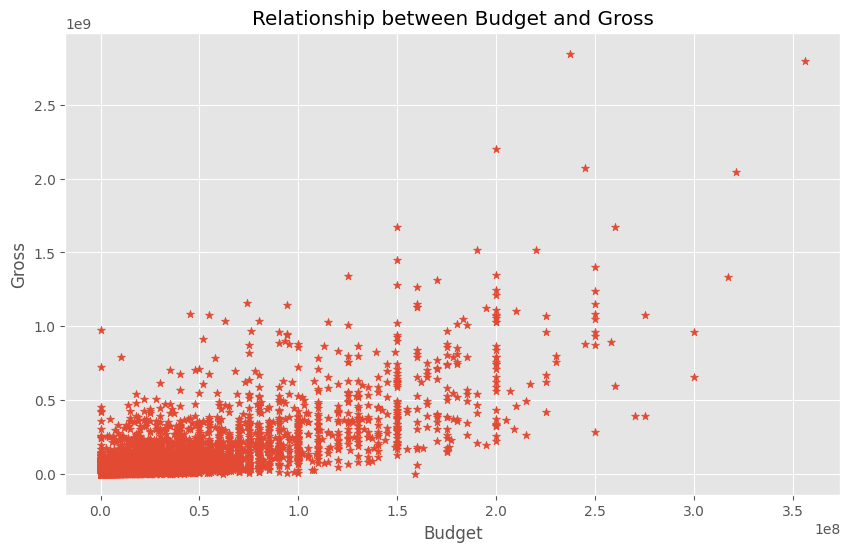

In [14]:

# Step 1: Calculate the correlation between gross and  budget
corr_bu_gr = data['budget'].corr(data['gross'])

# Step 2: Print the correlation between budget and gross
print(corr_bu_gr)

# Step 3: Create a scatter plot showing the relationship between gross and budget
plt.scatter(data['budget'], data['gross'], marker ="*")
plt.xlabel('Budget')
plt.ylabel('Gross')
plt.title('Relationship between Budget and Gross')
plt.show()

Q3 Visualize the different rating types of the movies. 

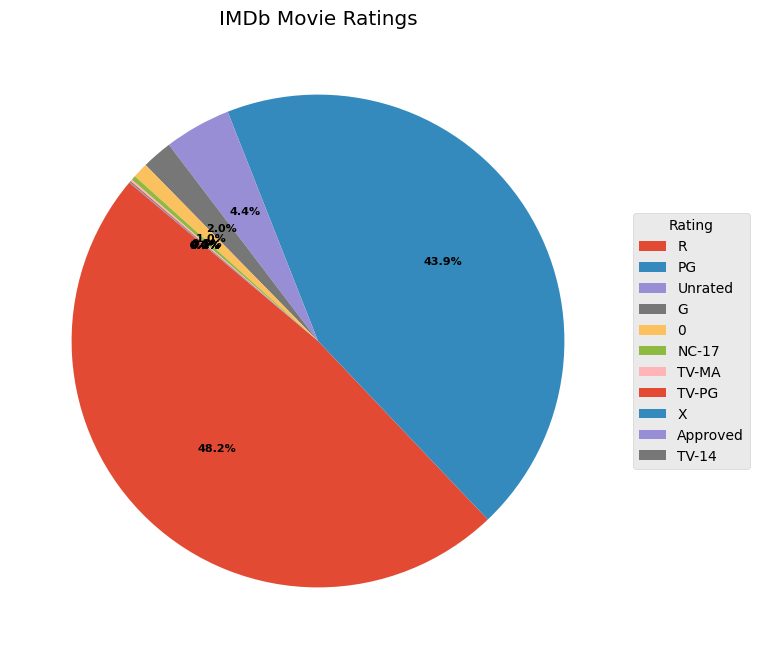

In [15]:
# Step 1: Aggregate data by rating
rating_counts = data['rating'].value_counts()


# Step 2: Plot Pie chart
fig, ax =plt.subplots(figsize =(10,8))
wedges,texts,autotexts = ax.pie(rating_counts, autopct="%1.1f%%", startangle=140)

ax.legend(wedges, rating_counts.index, title='Rating', loc ="center left", bbox_to_anchor=(1,0,0.5,1))

plt.setp(autotexts, size =8, weight ="bold")

ax.set_title("IMDb Movie Ratings")
plt.show()


From the above pie chart we have observe that "R" rating movies has the highest percentage.

Q4 Highest earnings genres of movies.

C:\Users\Anzi\AppData\Local\Temp\ipykernel_3240\150202122.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  average_earnings = data.groupby('genre')['gross'].mean()


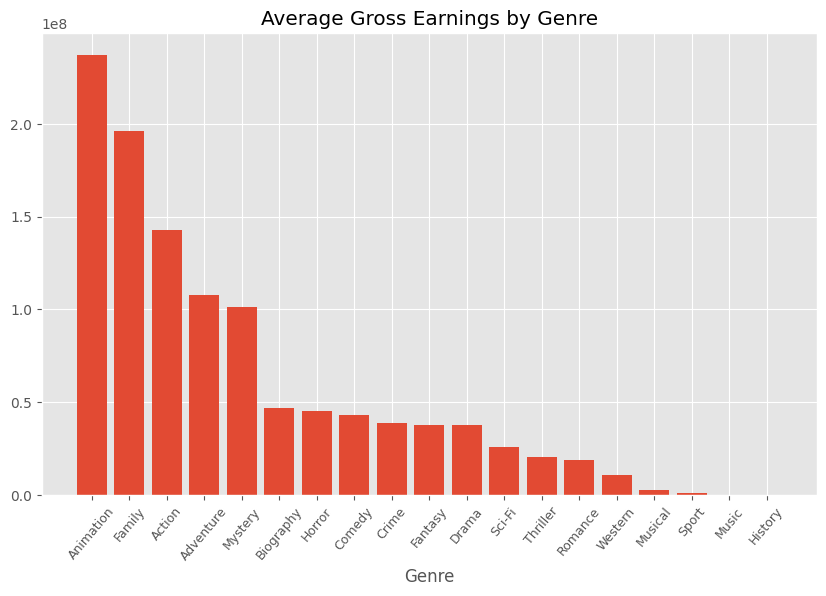

In [16]:
# Step 1: Grouping of data by genre and calculate the average gross earnings for each genre
average_earnings = data.groupby('genre')['gross'].mean()

# Step 2: Sort the genre by gross earnings in descending order
gross_earnings = average_earnings.sort_values(ascending=False)

# Step 3: Rotate the x-axis labels
plt.xticks(rotation=50)

# Step 4: Increase the font size of the x-axis labels
plt.xticks(fontsize=9)

# Step 5: Create a bar chart showing the average gross earnings for each genre
plt.bar(gross_earnings.index, gross_earnings)

# Step 6: Set the x-axis label and title
plt.xlabel('Genre')
plt.title('Average Gross Earnings by Genre')

# Step 7: Show the plot
plt.show()

Animation genere has the highest  gross earning.

Q5 Show the average budget of movies changed over time?

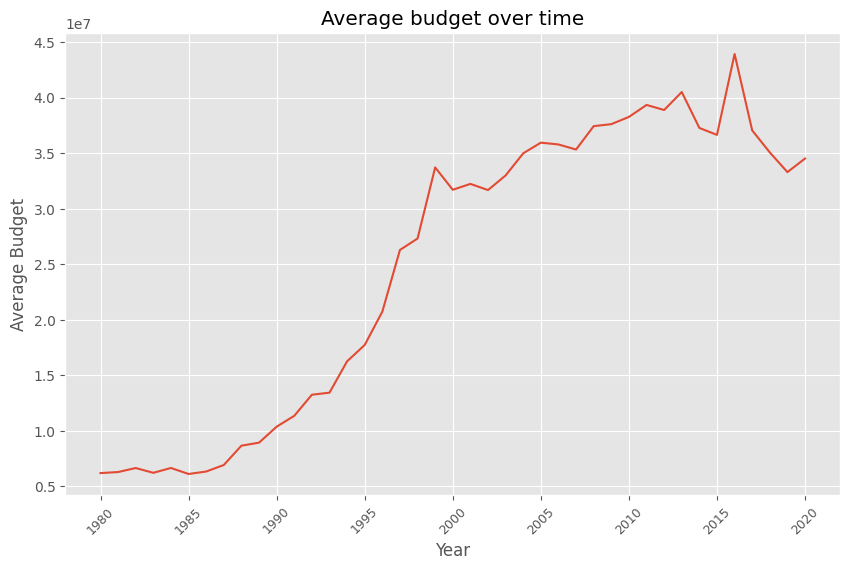

In [17]:

# Step 1: Group by year and calculate the average budget for each year

budget_per_year = data.groupby('year')['budget'].mean()

# Step 2: Rotate the x-axis labels
plt.xticks(rotation=45)

# Step 3: Increase the font size of the x-axis labels
plt.xticks(fontsize= 9)

# Step 4:  Create a line chart showing the average budget for each year
plt.plot(budget_per_year.index, budget_per_year)

# Step 5: Label the axis
plt.xlabel('Year')
plt.ylabel('Average Budget')

# Step 6: Label the title
plt.title('Average budget over time')
plt.show()

From the above line chart we observe that over the year 2017 the budget is decrease.

Q6.  Comparision of movies genere of drama and adventure with comedy in according to number of votes?

Text(0.5, 0, 'Types of Genre')

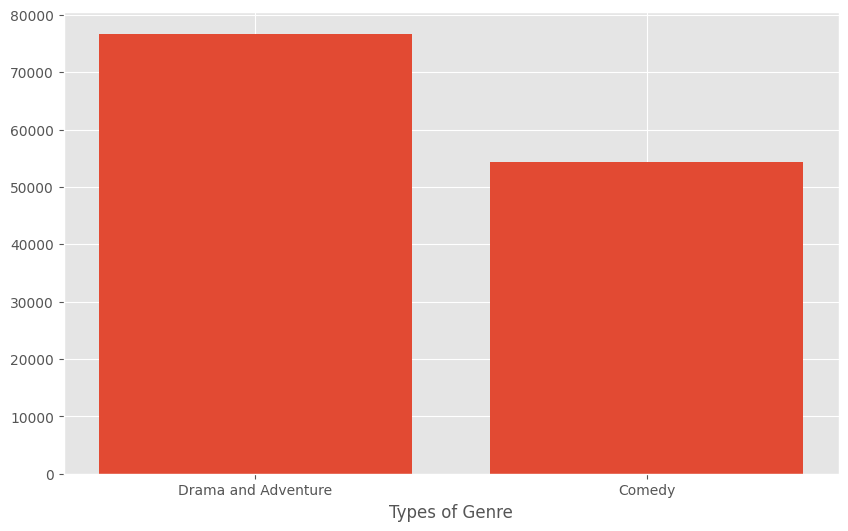

In [19]:
# Step 1: First filter the data of genre in drama and adventure
dra_adv = data[data['genre'].isin(['Drama','Adventure'])]


dra_adv_average_votes = dra_adv['votes'].mean()

# Step 2: Filter the data to only include comedy
com = data[data['genre'].isin(['Comedy'])]

# Step 4: Calculate the average votes
com_votes = com['votes'].mean()

# Create a bar chart showing the average gross earnings for summer movies and non-summer movies
plt.bar(['Drama and Adventure', 'Comedy'], [dra_adv_average_votes,  com_votes])
plt.xlabel('Types of Genre')

Q7 Show the comparision studies of budget and gross over the popularity.

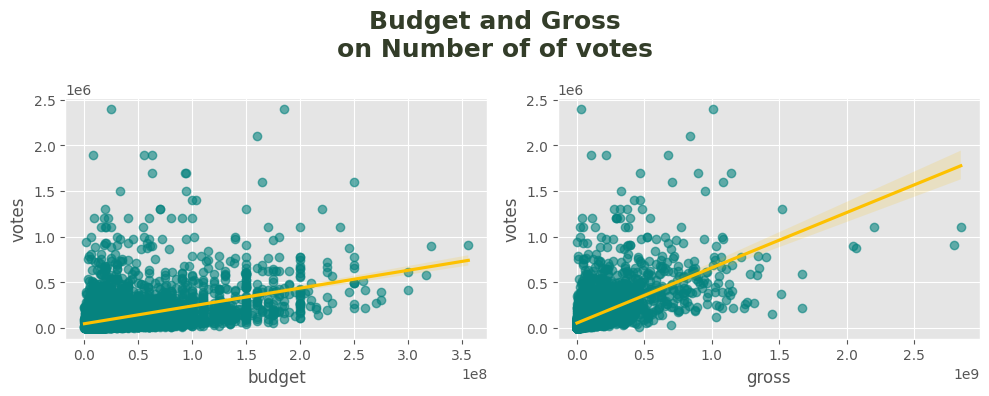

In [ ]:
# PLot the budget and Gross and compare with the number of votes
# Step 1: Collect the budget and gross data 
data_plot =data[(data['budget'] != 0) & (data['gross'] != 0)]

# Step 2: Compare by ploting into two different scatter subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

plt.suptitle('Budget and Gross\non Number of of votes', fontsize=18, weight=600, color='#333d29')
for i, col in enumerate(['budget', 'gross']):
    sns.regplot(data=data_plot, x=col, y='votes',
                scatter_kws={"color": "#06837f", "alpha": 0.6}, line_kws={"color": "#fdc100"}, ax=axes[i])

plt.tight_layout()

Q8 Show the different genere in pie cart and show the top 5 genere in bar chart?

In [23]:
import collections

C:\Users\Anzi\AppData\Local\Temp\ipykernel_3240\2242435561.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=data_plot, x='genre', y='total', ax=axes[0], palette=['#06837f', '#02cecb', '#b4ffff', '#f8e16c', '#fed811'])


(-1.25, 1.25, -1.25, 1.25)

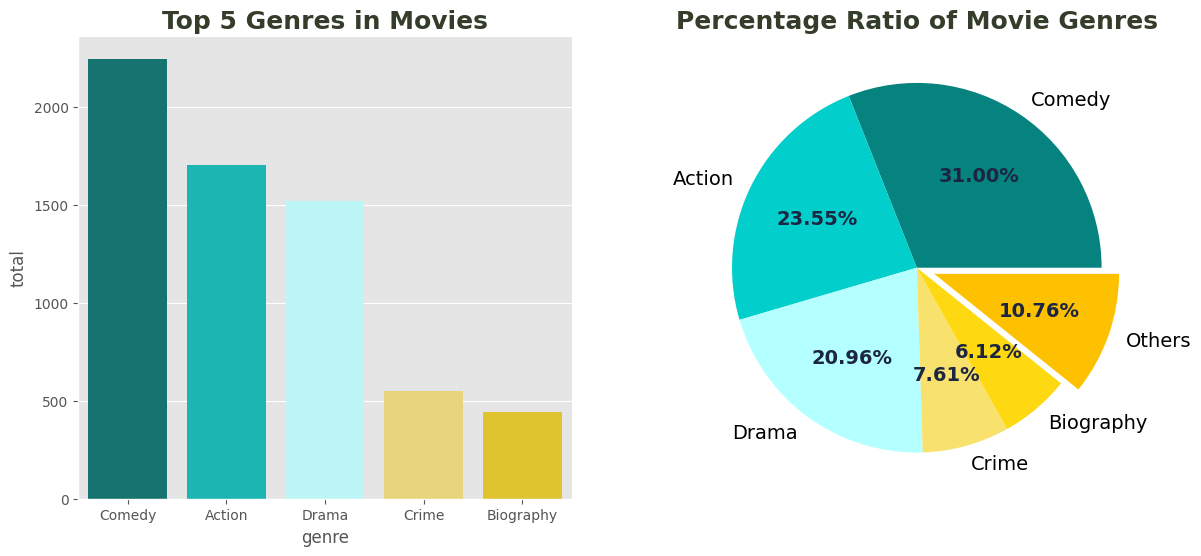

In [24]:
genres_list = []
for i in data['genre']:
    genres_list.extend(i.split(', '))

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14,6))

data_plot = pd.DataFrame(Counter(genres_list).most_common(5), columns=['genre', 'total'])
ax = sns.barplot(data=data_plot, x='genre', y='total', ax=axes[0], palette=['#06837f', '#02cecb', '#b4ffff', '#f8e16c', '#fed811'])
ax.set_title('Top 5 Genres in Movies', fontsize=18, weight=600, color='#333d29')
sns.despine()

data_plot_full = pd.DataFrame([Counter(genres_list)]).transpose().sort_values(by=0, ascending=False)
data_plot.loc[len(data_plot)] = {'genre': 'Others', 'total':data_plot_full[6:].sum()[0]}
plt.title('Percentage Ratio of Movie Genres', fontsize=18, weight=600, color='#333d29')
wedges, texts, autotexts = axes[1].pie(x=data_plot['total'], labels=data_plot['genre'], autopct='%.2f%%',
                                       textprops=dict(fontsize=14), explode=[0,0,0,0,0,0.1], colors=['#06837f', '#02cecb', '#b4ffff', '#f8e16c', '#fed811', '#fdc100'])

for autotext in autotexts:
    autotext.set_color('#1c2541')
    autotext.set_weight('bold')

axes[1].axis('off')